# Doc2Vec Model
-------------------------------------

In this example, we will download and preprocess the movie review data.

From this data set we will compute/fit a Doc2Vec model to get document vectors.  From these document vectors, we will split the documents into train/test and use these doc vectors to do sentiment analysis on the movie review dataset.

We start by loading the necessary libraries.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

If a temporary data folder does not exist, create it for saving the trained doc2vec embeddings.

In [3]:
# Make a saving directory if it doesn't exist
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

Start a computational graph session.

In [4]:
sess = tf.Session()

Next we declare the model parameters.

In [5]:
batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200   # Word embedding size
doc_embedding_size = 100   # Document embedding size
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size/2)    # Number of negative examples to sample.
window_size = 3       # How many words to consider to the left.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

Now we declare stop words, validation test words, and normalize the review text.

In [7]:
# Declare stop words
#stops = stopwords.words('english')
stops = []

# We pick a few test words for validation.
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# Later we will have to transform these into indices

# Load the movie review data
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]    
assert(len(target)==len(texts))
print('Done.')

Loading Data
Normalizing Text Data
Done.


Next we build our dictionary and transform the text data and validation words accordingly.

In [8]:
# Build our data set and dictionaries
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]
print('Done.')

Creating Dictionary
Done.


We now create our doc2vec model.  There will be two embeddings, a word embedding and a document embedding.

From these two embeddings, we add together the word embeddings and concatenate them to the document embeddings.

In [9]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))

# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                               stddev=1.0 / np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1]) # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding
# Add together element embeddings in window:
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

doc_indices = tf.slice(x_inputs, [0,window_size],[batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings,doc_indices)

# concatenate embeddings
final_embed = tf.concat(axis=1, values=[embed, tf.squeeze(doc_embed)])
print('Done.')

Creating Model
Done.


Next we declare our loss function, optimization function, cosine similarity, model saving operations, and initialize the model variables.

In [12]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=final_embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))
                                     
# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

Now we can train the doc2vec embedding model.  (This may take a while.  On a desktop computer with TensorFlow running on a CPU, it takes about 20-30 minutes to train the embedding.)

In [13]:
# Run the doc2vec model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(train_step, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 100 : 618.0488891601562
Loss at step 200 : 617.23876953125
Loss at step 300 : 599.1314697265625
Loss at step 400 : 570.5725708007812
Loss at step 500 : 556.9442138671875
Loss at step 600 : 530.82763671875
Loss at step 700 : 559.087646484375
Loss at step 800 : 550.006103515625
Loss at step 900 : 510.2719421386719
Loss at step 1000 : 498.8831787109375
Loss at step 1100 : 471.5820617675781
Loss at step 1200 : 494.06304931640625
Loss at step 1300 : 424.6642150878906
Loss at step 1400 : 434.5860595703125
Loss at step 1500 : 471.4763488769531
Loss at step 1600 : 392.48760986328125
Loss at step 1700 : 426.09637451171875
Loss at step 1800 : 396.0362548828125
Loss at step 1900 : 380.9305114746094
Loss at step 2000 : 311.42388916015625
Loss at step 2100 : 363.8681945800781
Loss at step 2200 : 352.4156188964844
Loss at step 2300 : 397.03558349609375
Loss at step 2400 : 315.4415588378906
Loss at step 2500 : 318.6441955566406
Loss at step 2600 : 305.4302978515625
Loss

## Now we can use the above embeddings to train a logistic model to predict sentiment.
---------------------------

Here are some parameters of the logistic model:

In [14]:
max_words = 20
logistic_batch_size = 500

Split dataset into train and test sets.

In [15]:
# Need to keep the indices sorted to keep track of document index
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# Convert texts to lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

Now we define our logistic model.  First the placeholders, then the embeddings (word and document embeddings from above training), and then our logistic regression operations.

In [16]:
# Define Logistic placeholders
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

# Define logistic embedding lookup (needed if we have two different batch sizes)
# Add together element embeddings in window:
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words],[logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings,log_doc_indices)

# concatenate embeddings
log_final_embed = tf.concat(axis=1, values=[log_embed, tf.squeeze(log_doc_embed)])

# Define model:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[concatenated_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(log_final_embed, A), b)

Loss function, Prediction function, Optimization function and variable initializer.

In [17]:
# Declare loss function (Cross Entropy loss)
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=tf.cast(log_y_target, tf.float32)))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A, b])

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

Now we start our logistic regression training for sentiment.

In [18]:
# Start Logistic Regression
print('Starting Logistic Doc2Vec Model Training')
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    # Append review index at the end of text data
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs : rand_x, log_y_target : rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        # Append review index at the end of text data
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)

        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Starting Logistic Doc2Vec Model Training
Generation # 500. Train Loss (Test Loss): 7.39 (7.18). Train Acc (Test Acc): 0.52 (0.49)
Generation # 1000. Train Loss (Test Loss): 5.37 (5.51). Train Acc (Test Acc): 0.48 (0.51)
Generation # 1500. Train Loss (Test Loss): 3.65 (3.86). Train Acc (Test Acc): 0.57 (0.56)
Generation # 2000. Train Loss (Test Loss): 2.61 (3.02). Train Acc (Test Acc): 0.54 (0.50)
Generation # 2500. Train Loss (Test Loss): 2.14 (2.59). Train Acc (Test Acc): 0.58 (0.51)
Generation # 3000. Train Loss (Test Loss): 1.81 (2.16). Train Acc (Test Acc): 0.59 (0.54)
Generation # 3500. Train Loss (Test Loss): 2.15 (2.43). Train Acc (Test Acc): 0.53 (0.52)
Generation # 4000. Train Loss (Test Loss): 2.21 (2.20). Train Acc (Test Acc): 0.55 (0.54)
Generation # 4500. Train Loss (Test Loss): 2.33 (2.91). Train Acc (Test Acc): 0.54 (0.52)
Generation # 5000. Train Loss (Test Loss): 2.54 (2.65). Train Acc (Test Acc): 0.51 (0.50)
Generation # 5500. Train Loss (Test Loss): 2.15 (2.62). Trai

Here is matplotlib code for plotting the train/test loss and accuracy.

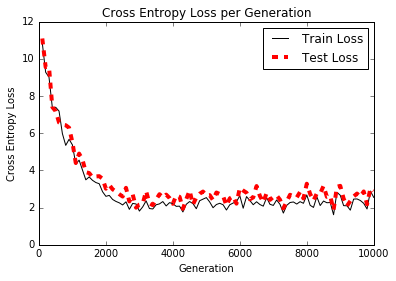

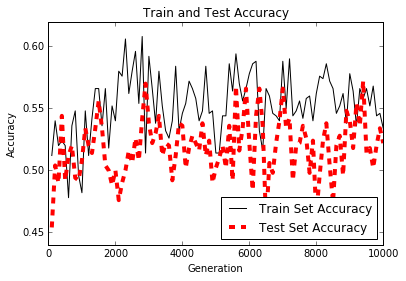

In [19]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

To make improvements, we should focus on improving the doc2vec embeddings.  Potential doc2vec improvements may come with stemming of words, expanding stop words, and more training.

And for improving the logistic regression, we could add a hidden layer and also increase batch size and exponentially reduce the learning rate.